In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib notebook

[Link to article](https://towardsdatascience.com/social-distancing-to-slow-the-coronavirus-768292f04296)

The SEIR model is a compartmental model for modeling how a disease spreads through a population. It’s an acronym for Susceptible, Exposed, Infected, Recovered. When a disease is introduced to a population, the people move from one of these classes (or compartments) to the next. When they reach the R state, they’re no longer able to be infected, depending on your interpretation, they either survived the disease and are now immune or succumbed to the illness and are out of the population.

$$
\frac{\text{d}S}{\text{d}t} = -\beta SI     \hspace{30mm} (1)
$$

$$
\frac{\text{d}E}{\text{d}t} = \beta SI - \alpha E     \hspace{30mm} (2)
$$

$$
\frac{\text{d}I}{\text{d}t} = \alpha E - \gamma I    \hspace{30mm}  (3)
$$

$$
\frac{\text{d}R}{\text{d}t} = \gamma I      \hspace{30mm} (4)
$$

$$
N = S + E + I + R     \hspace{30mm} (5)
$$


We have four ODE’s in the time domain, with three parameters: α, β, and γ.
α is the inverse of the incubation period (1/t_incubation)
β is the average contact rate in the population
γ is the inverse of the mean infectious period (1/t_infectious)
Equation (1) is the change in people susceptible to the disease and is moderated by the number of infected people and their contact with the infected. Equation (2) gives the people who have been exposed to the disease. It grows based on the contact rate and decreases based on the incubation period whereby people then become infected.
Equation (3) gives us the change in infected people based on the exposed population and the incubation period. It decreases based on the infectious period, so the higher γ is, the more quickly people die/recover and move on to the final stage in Equation (4). The final equation, number (5), is a constraint that indicates there are no birth/migration effects in the model; we have a fixed population from beginning to end.
There’s one more parameter we should discuss, the infamous R0 value.

This value defines how quickly the disease spreads and can be related to our parameters through the relationship given in Equation (6).

$$
R_{0} = \frac{\beta}{\gamma}
$$


Modeling Coronavirus
With these equations, we can build our model for the coronavirus itself to try to better understand how it might spread. The key is determining our values for α, β, and γ so we can see how it might spread.
A recent study of COVID-19 estimates some of these values for us (Hellewell et al. 2020), so we can use some of their parameter estimates to get our model off the ground.
Incubation period = 5 days -> α = 0.2
R0 = 3.5
Unfortunately, this paper doesn’t provide a value for γ, but we can get an estimate from another paper (which uses a more complex compartmental model) to get our 1/γ value of 2 days, so γ = 0.5.
Plugging the R0 and γ values into Equation (6), we get an estimate of β = 1.75.
Now, it’s time to put this model into Python.

Base SEIR Model in Python
We’ll simulate this using the semi-implicit Euler method — just like I demonstrated with the SIR model. This just requires taking our most recent values for S, E, I, and R, and adding the equation multiplied by our time step. The code for this is as follows:

$$
\frac{\text{d}S}{\text{d}t} = -\rho \beta SI     \hspace{30mm} (1)
$$

$$
\frac{\text{d}E}{\text{d}t} = \rho \beta SI - \alpha E     \hspace{30mm} (2)
$$

In [3]:
def base_seir_model(init_vals, params, t):
    S_0, E_0, I_0, R_0 = init_vals
    S, E, I, R = [S_0], [E_0], [I_0], [R_0]
    alpha, beta, gamma = params
    dt = t[1] - t[0]
    for _ in t[1:]:
        next_S = S[-1] - (beta*S[-1]*I[-1])*dt
        next_E = E[-1] + (beta*S[-1]*I[-1] - alpha*E[-1])*dt
        next_I = I[-1] + (alpha*E[-1] - gamma*I[-1])*dt
        next_R = R[-1] + (gamma*I[-1])*dt
        S.append(next_S)
        E.append(next_E)
        I.append(next_I)
        R.append(next_R)
    return np.stack([S, E, I, R]).T

For any system of ODE’s, we need to provide initial values. We’ll use normalized population values for our S_0, E_0, etc. So if we assume we have 10k people in our population, and we begin with one exposed person and the remaining 9,999 susceptible, we have:
S_0 = 1–1/10,000
E_0 = 1/10,000
I_0 = 0
R_0 = 0
Now, we can turn to the simulation itself by plugging these values into Python with a 1 day time step.

In [4]:
# Define parameters
t_max = 100
dt = .1
t = np.linspace(0, t_max, int(t_max/dt) + 1)
N = 10000
init_vals = 1 - 1/N, 1/N, 0, 0
alpha = 0.2
beta = 1.75
gamma = 0.5
params = alpha, beta, gamma
# Run simulation
results = base_seir_model(init_vals, params, t)

We’re primarily interested in the flattening effect of social distancing, so let’s just plot the E and I terms of simulation.

In [6]:
data = pd.DataFrame(data = results)
data.index = t
data.columns = ['S', 'E', 'I', 'R' ]
data[['E', 'I']].plot()

In [8]:
data.index = t

In [9]:
data.columns = ['S', 'E', 'I', 'R' ]

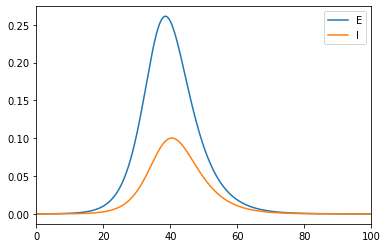

In [11]:
data[['E', 'I']].plot()

We see our base case without social distancing. It shows that, at the peak, 10% of our population will be infected with the disease after 40 days from the first exposure. This has a good chance of being a very severe infection, even if it is relatively short lived.
Let’s turn to the effects of social distancing and how to model it.
Coronavirus with Social Distancing
Social distancing includes avoiding large gatherings, physical contact, and other efforts to mitigate the spread of infectious disease. According to our model, the term this is going to impact is our contact rate, β.
Let’s introduce a new value, ρ, to capture our social distancing effect. This is going to be a constant term between 0–1, where 0 indicates everyone is locked down and quarantined while 1 is equivalent to our base case above. To introduce this into our model, we’ll modify Equations (1) and (2) above by multiplying this with our β and writing Equations (1') and (2').

If we go back to our baseline model, we just need to add the ρ value to our code as shown below.
def seir_model_with_soc_dist(init_vals, params, t):
    S_0, E_0, I_0, R_0 = init_vals
    S, E, I, R = [S_0], [E_0], [I_0], [R_0]
    alpha, beta, gamma, rho = params
    dt = t[1] - t[0]
    for _ in t[1:]:
        next_S = S[-1] - (rho*beta*S[-1]*I[-1])*dt
        next_E = E[-1] + (rho*beta*S[-1]*I[-1] - alpha*E[-1])*dt
        next_I = I[-1] + (alpha*E[-1] - gamma*I[-1])*dt
        next_R = R[-1] + (gamma*I[-1])*dt
        S.append(next_S)
        E.append(next_E)
        I.append(next_I)
        R.append(next_R)
    return np.stack([S, E, I, R]).T
If we set ρ to 1, 0.8, and 0.5, we can visualize the flattening effect as we increase our efforts to contain the disease through simple, every day actions.

Here again, I show the E and I values for our model color-coded by the social distancing factor ρ. We can see the flattening effect take place here as more social distancing takes place throughout the population, which makes intuitive sense as it reduces the contact rate. We go from a base case peak of 10% of the population being infected simultaneously to about 7.5% to a low of 3%. Notice too that it gives people more time to prepare as the peak gets pushed farther out into the future.
These scenarios with social distancing will likely improve the survivability of the disease by giving more time for treatments and supplies to develop while keeping the peaks lower.

In [13]:
def seir_model_with_soc_dist(init_vals, params, t):
    S_0, E_0, I_0, R_0 = init_vals
    S, E, I, R = [S_0], [E_0], [I_0], [R_0]
    alpha, beta, gamma, rho = params
    dt = t[1] - t[0]
    for _ in t[1:]:
        next_S = S[-1] - (rho*beta*S[-1]*I[-1])*dt
        next_E = E[-1] + (rho*beta*S[-1]*I[-1] - alpha*E[-1])*dt
        next_I = I[-1] + (alpha*E[-1] - gamma*I[-1])*dt
        next_R = R[-1] + (gamma*I[-1])*dt
        S.append(next_S)
        E.append(next_E)
        I.append(next_I)
        R.append(next_R)
    return np.stack([S, E, I, R]).T

In [29]:
# Define parameters
t_max = 200
dt = .1
t = np.linspace(0, t_max, int(t_max/dt) + 1)
N = 10000
init_vals = 1 - 1/N, 1/N, 0, 0
alpha = 0.2
beta = 1.75
gamma = 0.5
rho = 0.5
params = alpha, beta, gamma, rho
# Run simulation
results = seir_model_with_soc_dist(init_vals, params, t)

In [30]:
data2 = pd.DataFrame(data = results)
data2.columns = ['S', 'E', 'I', 'R' ]
data2.index = t

<IPython.core.display.Javascript object>


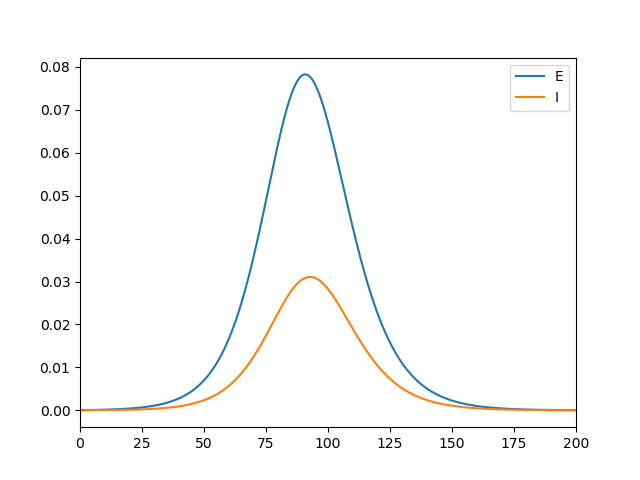

<IPython.core.display.Javascript object>


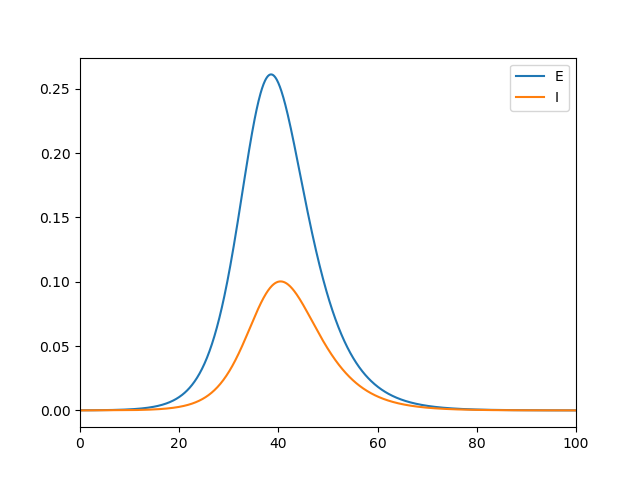

In [31]:
data2[['E', 'I']].plot()
data[['E', 'I']].plot()